In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import chardet as chardet
with open('test2.csv', 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

# pd.read_csv('filename.csv', encoding=result['encoding'])
df = pd.read_csv('test2.csv',delimiter=',',encoding=result['encoding'])
# df = pd.read_csv('./test2.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,한글도 될까요?,NaN,NaN,NaN
1,ham,이런식으로 말이에요,NaN,NaN,NaN
2,spam,공짜 입니다,NaN,NaN,NaN
3,spam,공짜 광고 입니다,NaN,NaN,NaN
4,ham,정말 될지 모르겠네요,NaN,NaN,NaN


In [3]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
v1    26 non-null object
v2    26 non-null object
dtypes: object(2)
memory usage: 496.0+ bytes


Text(0.5,1,'Number of ham and spam messages')

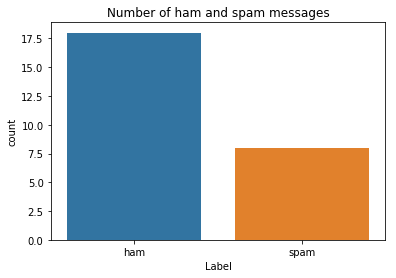

In [4]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [5]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [7]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [8]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [9]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [10]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 17 samples, validate on 5 samples
Epoch 1/10
17/17 [==============================] - 1s 64ms/step - loss: 0.6906 - acc: 0.6471 - val_loss: 0.6872 - val_acc: 0.6000
Epoch 2/10
17/17 [==============================] - 0s 7ms/step - loss: 0.6774 - acc: 0.7059 - val_loss: 0.6792 - val_acc: 0.6000
Epoch 3/10
17/17 [==============================] - 0s 8ms/step - loss: 0.6600 - acc: 0.7059 - val_loss: 0.6701 - val_acc: 0.6000
Epoch 4/10
17/17 [==============================] - 0s 8ms/step - loss: 0.6298 - acc: 0.7059 - val_loss: 0.6704 - val_acc: 0.6000


In [11]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [12]:
accr = model.evaluate(test_sequences_matrix,Y_test)

4/4 [==============================] - 0s 4ms/step


In [13]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.580
  Accuracy: 0.750
